In [110]:
import numpy as np
import matplotlib.pyplot as plt
import os

class VineyardSurrogate:
    def __init__(self, grid_rows=16, grid_cols=12, et_coeff=0.05, 
                 optimal_low=0.25, optimal_high=0.6, stages_duration=50, 
                 end_on_death=False, diffusion=False, rand_et=False):
        """
        Initialize the vineyard surrogate model
        
        Parameters:
        - grid_rows, grid_cols: Dimensions of the grid (e.g., 16x12) will be changed to assist with model speed and resolution.
        - et_coeff: Paraemeter to control water loss per step..
        - optimal_low, optimal_high: Bounds for optimal water level, outside of bounds pentalties start
        - stages_duration: Time steps per growth stage.
        - end_on_death: If True, simulation ends early if any crop dies. (should assist with RL training speeds)
        - diffusion: If True, enable water diffusion between cells (not implemented yet).
        """

        #User Specicied Variables
        self.rows = grid_rows
        self.cols = grid_cols
        self.optimal_low = optimal_low
        self.optimal_high = optimal_high
        self.stages_duration = stages_duration
        self.total_steps = stages_duration * 4
        self.end_on_death = end_on_death
        self.diffusion = diffusion
        self.et_coeff = np.full((self.rows, self.cols), et_coeff)
        #Modify ET to add some variability
        if rand_et:
            self.et_random_factor = np.clip(np.random.normal(1.0, 0.1, (self.rows, self.cols)), 0.8, 1.2)
        else:
            self.et_random_factor = np.ones((self.rows, self.cols))

        #Model Variables
        self.stages = ['Bud Break', 'Flowering', 'Fruit Set', 'Ripening', 'Harvest']
        self.max_water = 1 #Normalized max quantity of water soil can absorb
        self.current_step = 0
        self.current_stage = 0
        self.time_in_stage = np.zeros((self.rows, self.cols), dtype=int)  # Time steps in current stage per cell
        self.alive = np.ones((self.rows, self.cols), dtype=bool)  # Alive/dead per cell
        self.water = np.full((self.rows, self.cols), 0.5)  # Initial even water level
        self.quantity_grid = np.zeros((self.rows, self.cols))  # Per-cell quantity
        self.quality_grid = np.ones((self.rows, self.cols))  # Per-cell quality
        self.total_water_usage = 0.0  # Total irrigation water used (inch-acres)

        #Turnable stage parameters (tune to model realistic grape growth across different stages)
        self.stage_params = {
            0: {'qty_rate': 0.00005, 'under_penalty': -0.05, 'over_penalty': 0.1, 'qual_factor': 0.001},
            1: {'qty_rate': 0.0001, 'under_penalty': -0.1, 'over_penalty': 0.5, 'qual_factor': 0.002},
            2: {'qty_rate': 0.0003, 'under_penalty': -0.9, 'over_penalty': 3.5, 'qual_factor': 0.005},
            3: {'qty_rate': 0.00015, 'under_penalty': -0.5, 'over_penalty': 0.5, 'qual_factor': 0.015}
        }
        
        #Store simulation history for graphing
        self.water_history = []
        self.quantity_history = []
        self.quality_history = []
        self.usage_history = []

    def reset(self):
        """Reset the simulation to initial state."""
        self.__init__(grid_rows=self.rows, grid_cols=self.cols, et_coeff=self.et_coeff, 
                      optimal_low=self.optimal_low, optimal_high=self.optimal_high, 
                      stages_duration=self.stages_duration, end_on_death=self.end_on_death, 
                      diffusion=self.diffusion, rand_et=self.rand_et)
    
    def step(self, rainfall=0.0, irrigation=None):
        """
        Advance the simulation by one time step.
        
        Parameters:
        - rainfall: Uniform rainfall amount (inches) added to all cells.
        - irrigation: 2D array of irrigation amounts per cell (inches).
        
        Returns:
        - done: True if simulation ended (200 steps or death if enabled).
        - info: Dict with current quantity, quality, water_usage.
        """

        #Check if current step is past total step limit
        if self.current_step >= self.total_steps:
            return True, self.get_info()

        if irrigation is None:
            irrigation = np.zeros((self.rows, self.cols))
            
        #Add rainfall and irrigation
        self.water += rainfall/4 
        self.water += irrigation/4
        self.total_water_usage += np.sum(irrigation) / (self.rows * self.cols)  # Average inch-acres
        
        #Check for crop death due to water
        over_water = self.water > self.max_water #Death by drowning
        under_water = self.water < 0  #Death by drought
        dead_cells = over_water | under_water 
        new_dead = dead_cells & self.alive
        
        #Set cells to dead and set quantity and quality to 0
        self.alive[dead_cells] = False
        self.quantity_grid[dead_cells] = 0.0
        self.quality_grid[dead_cells] = 0.0

        #Check for dead cells and end on death
        if self.end_on_death and np.any(~self.alive):
            return True, self.get_info()

        
        #Evapotranspiration loss
        et_loss = self.et_coeff * np.sqrt(self.water) * self.et_random_factor #Simple water loss per step (more water = larger loss)
        self.water = np.maximum(self.water - et_loss, 0.0)
        
        #Diffusion (spread water to adjacent cells [WIP])
        if self.diffusion:
            pass  #Not implimented yet
        
        # Update growth
        self.update_growth()
        
        # Advance time
        self.current_step += 1
        self.time_in_stage += 1
        
        # Check stage transition
        if self.time_in_stage[0,0] >= self.stages_duration:
            self.current_stage += 1
            self.time_in_stage.fill(0)
            self.print_stage_graphs()
        
        # Record history 
        self.water_history.append(np.mean(self.water))
        self.quantity_history.append(np.sum(self.quantity_grid))
        self.quality_history.append(np.mean(self.quality_grid))
        self.usage_history.append(self.total_water_usage)
        
        done = self.current_step >= self.total_steps
        return done, self.get_info()

    def update_growth(self):
        """Update quantity and quality based on current water and stage."""

        #get parameters based on growth stage
        params = self.stage_params[self.current_stage]
        alive_mask = self.alive.astype(float)
        
        #Quantity change
        under = self.water < self.optimal_low
        over = self.water > self.optimal_high
        
        qty_deltas = (params['qty_rate'] * (1 + params['under_penalty'] * under.astype(float) + params['over_penalty'] * over.astype(float)))
        self.quantity_grid += qty_deltas * alive_mask
        
        #Quality change

        #Water penalty
        dev_under = np.maximum(self.optimal_low - self.water, 0)
        dev_over = np.maximum(self.water - self.optimal_high, 0)
        water_penalties = params['qual_factor'] * (dev_under + dev_over)

        #Quantity penalty
        total_quantity = np.sum(self.quantity_grid)
        qty_penalty = 0
        if total_quantity > 5:
            qty_penalty = params['qual_factor']* 0.1 * (total_quantity - 5) 
        
        self.quality_grid -= (water_penalties + qty_penalty) * alive_mask
        self.quality_grid = np.maximum(self.quality_grid, 0)

    def get_info(self):
        """Get current simulation info."""
        return {
            'quantity': np.sum(self.quantity_grid),
            'quality': np.mean(self.quality_grid),
            'water_usage': self.total_water_usage,
            'stage': self.stages[self.current_stage],
            'step': self.current_step,
            'any_dead': np.any(~self.alive)}

    def print_stage_graphs(self):
        """Print field-wide graphs every stage change and return image."""
        
        print(f"Stage {self.stages[self.current_stage - 1]} completed at step {self.current_step}")
        print("Average ET Coefficient:", np.mean(self.et_coeff))
        print("Average Water Level:", np.mean(self.water))
        print("Crop State: Quantity={:.2f}, Quality={:.2f}".format(np.sum(self.quantity_grid), np.mean(self.quality_grid)))
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        # Water Grid
        im0 = axs[0].imshow(self.water, cmap='Blues', vmin=0, vmax=1)
        axs[0].set_title('Water Grid')
        fig.colorbar(im0, ax=axs[0])
        
        # Growth Grid: Use -1 for dead cells and set under-color to black
        growth_vis = self.quantity_grid.copy()
        growth_vis[~self.alive] = -1
        cmap = plt.get_cmap('Greens').copy()
        cmap.set_under(color='black')
        im1 = axs[1].imshow(growth_vis, cmap=cmap, vmin=0, vmax=3.0)
        axs[1].set_title('Growth Grid (Black=Dead)')
        fig.colorbar(im1, ax=axs[1])
        
        # Quality Grid
        im2 = axs[2].imshow(self.quality_grid, cmap='Oranges', vmin=0, vmax=1)
        axs[2].set_title('Quality Grid')
        fig.colorbar(im2, ax=axs[2])
        
        plt.tight_layout()
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.show(fig)
        plt.close('all')

    def plot_histories(self):
        """Plot simulation histories."""
        steps = range(len(self.water_history))
        fig, axs = plt.subplots(4, 1, figsize=(10, 12))
        
        axs[0].plot(steps, self.water_history)
        axs[0].set_title('Average Water Level Over Time')
        
        axs[1].plot(steps, self.quantity_history)
        axs[1].set_title('Crop Quantity Over Time')
        
        axs[2].plot(steps, self.quality_history)
        axs[2].set_title('Crop Quality Over Time')
        
        axs[3].plot(steps, self.usage_history)
        axs[3].set_title('Total Water Usage Over Time')
        
        plt.tight_layout()
        plt.show()
        plt.close('all')

Stage Bud Break completed at step 50
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.21780279010919337
Crop State: Quantity=0.48, Quality=1.00


C:\Users\olson\AppData\Local\Temp\ipykernel_50384\3809937657.py:212: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


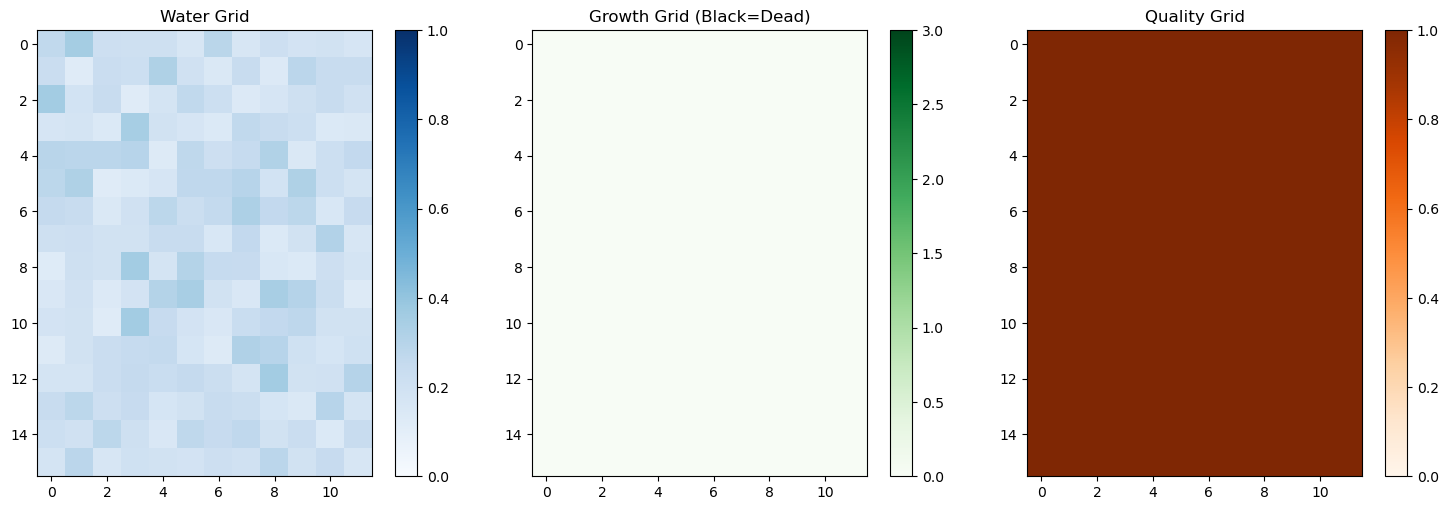

Stage Flowering completed at step 100
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.18981629835199054
Crop State: Quantity=1.38, Quality=1.00


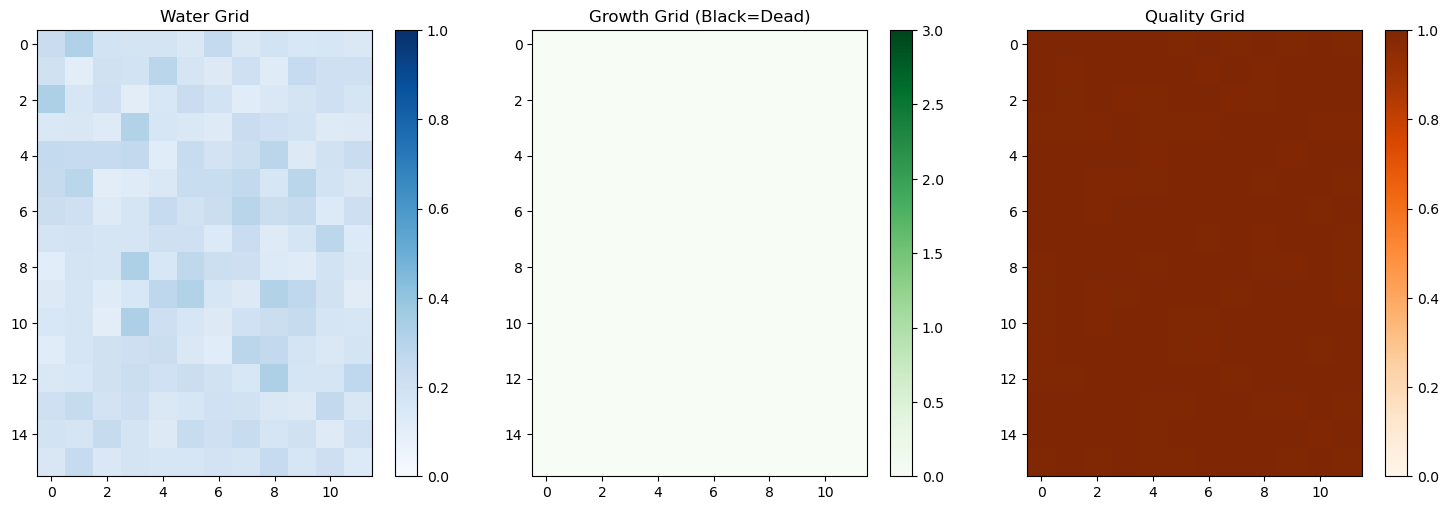

Stage Fruit Set completed at step 150
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.1871746778645382
Crop State: Quantity=2.68, Quality=0.99


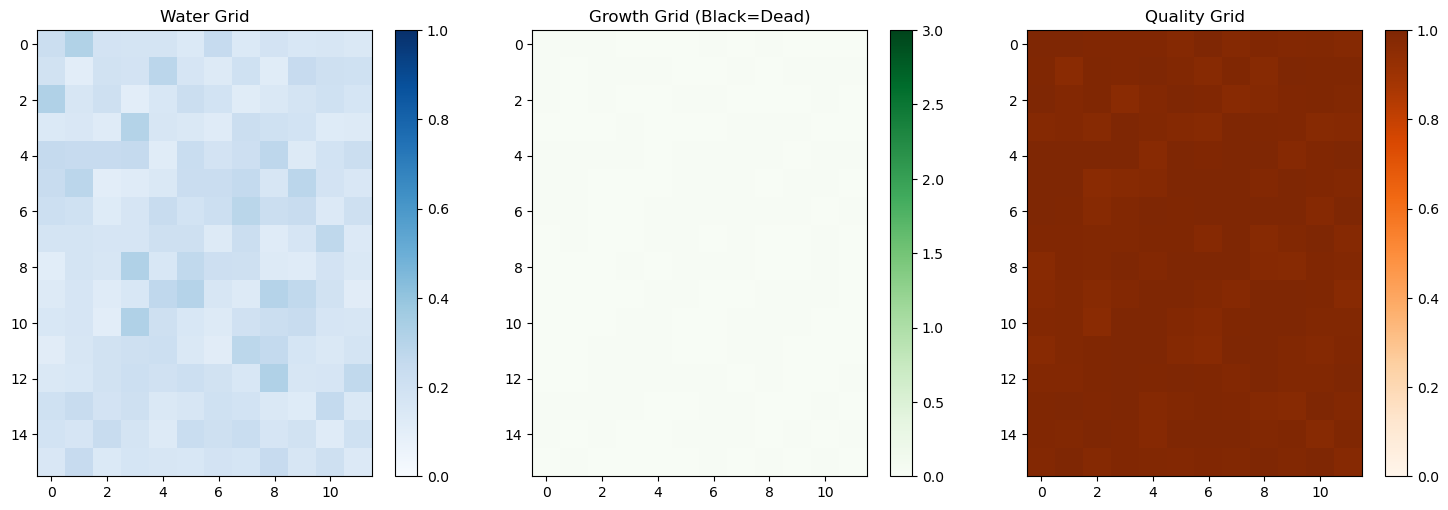

Stage Ripening completed at step 200
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.1868818742823611
Crop State: Quantity=3.67, Quality=0.96


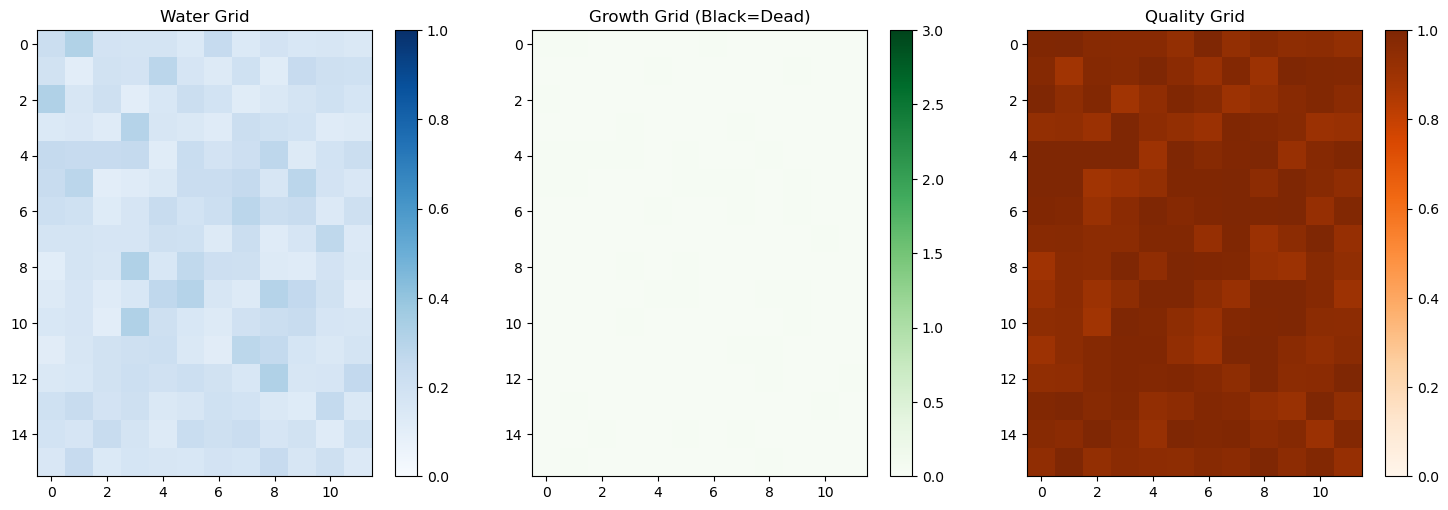

Final Results:
{'quantity': 3.6710125000000047, 'quality': 0.9627510045434615, 'water_usage': 20.0, 'stage': 'Harvest', 'step': 200, 'any_dead': False}


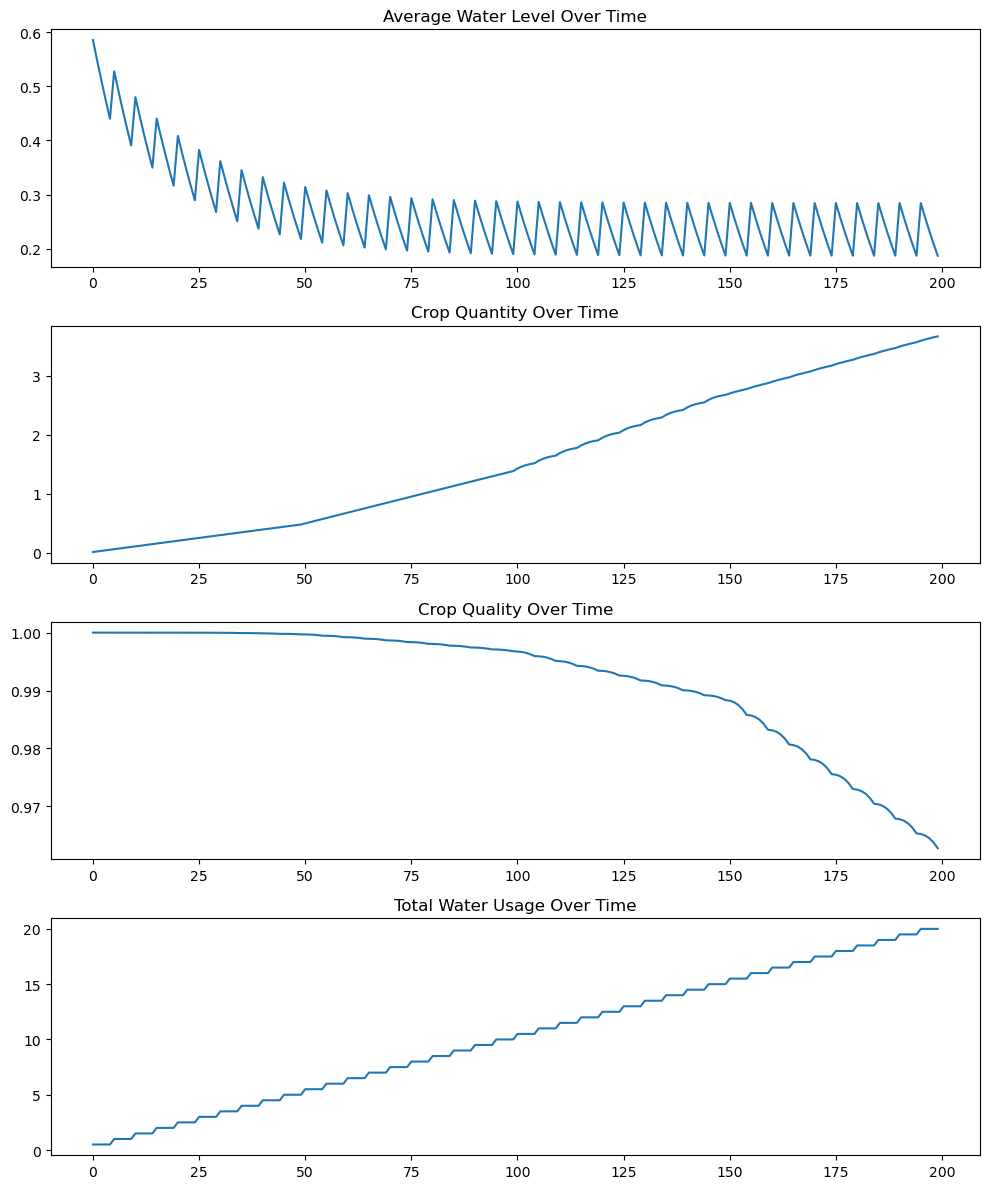

In [112]:
#Example
model = VineyardSurrogate(et_coeff=0.05, rand_et=True)

#Fixed irrigation every 5 days
irrigation_schedule = .5  # inches
done = False
while not done:
    rain = 0.0  # No rain for test
    irr = np.zeros((model.rows, model.cols))
    if model.current_step % 5 == 0:
        irr.fill(irrigation_schedule)
    done, info = model.step(rainfall=rain, irrigation=irr)
    
print("Final Results:")
print(info)
model.plot_histories()  # Would generate plots if run locally

Stage Bud Break completed at step 50
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.4644924044683771
Crop State: Quantity=0.49, Quality=1.00


C:\Users\olson\AppData\Local\Temp\ipykernel_50384\3809937657.py:212: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


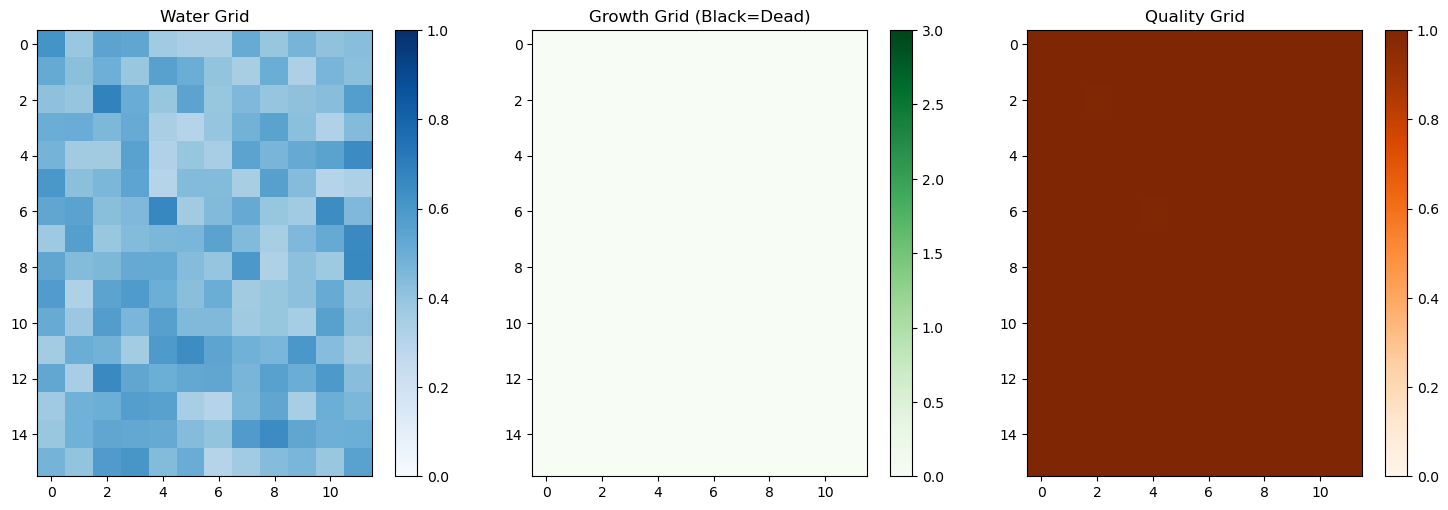

Stage Flowering completed at step 100
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.4623176177468893
Crop State: Quantity=1.59, Quality=1.00


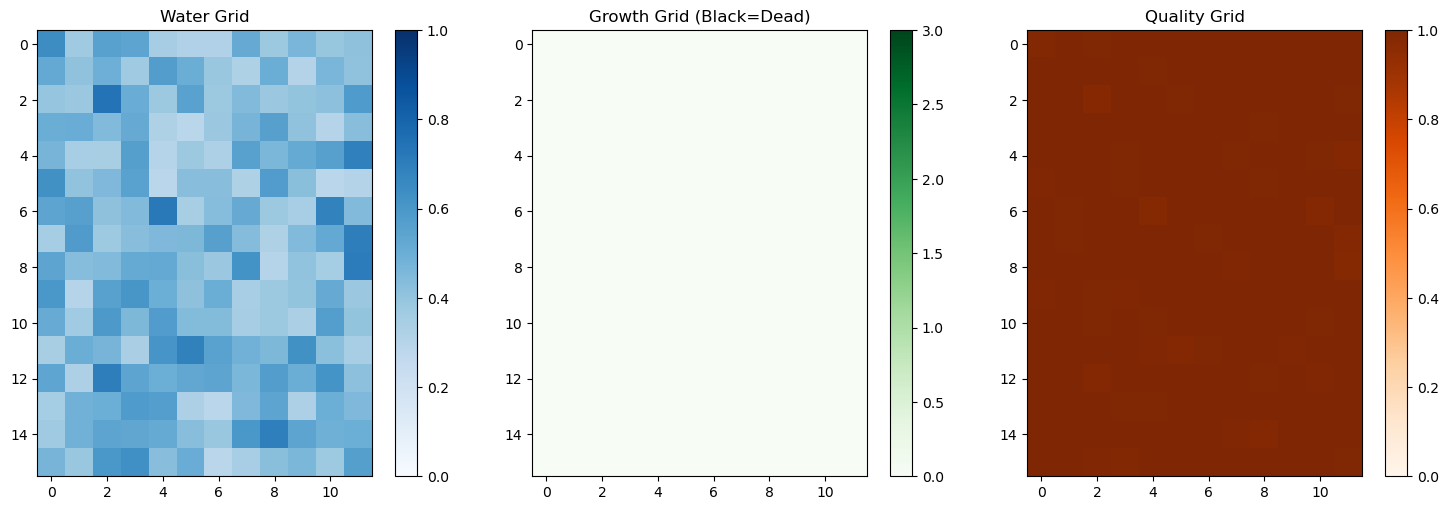

Stage Fruit Set completed at step 150
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.462824914669665
Crop State: Quantity=7.41, Quality=0.98


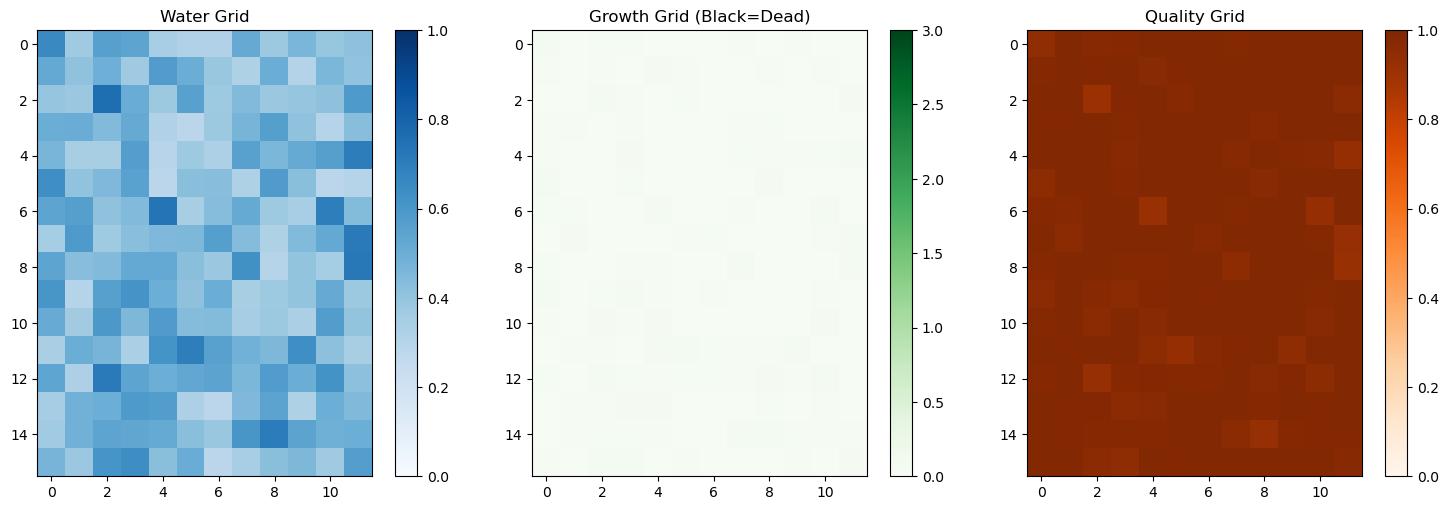

Stage Ripening completed at step 200
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.46311997428383744
Crop State: Quantity=9.06, Quality=0.72


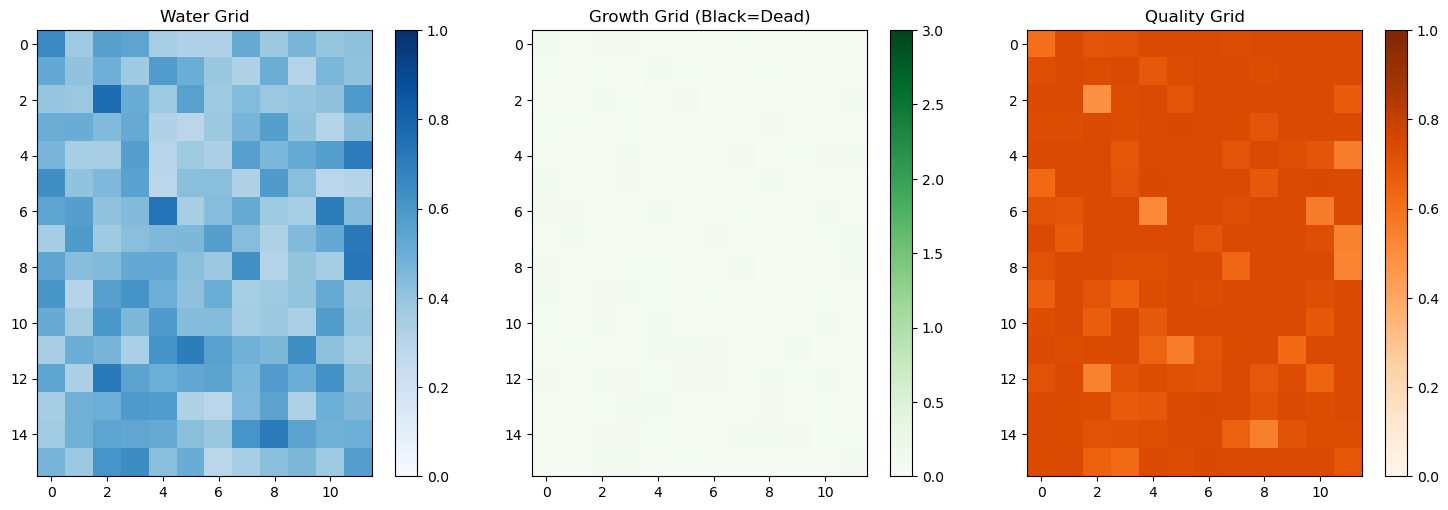

Final Results:
{'quantity': 9.063550000000014, 'quality': 0.715514864143462, 'water_usage': 30.0, 'stage': 'Harvest', 'step': 200, 'any_dead': False}


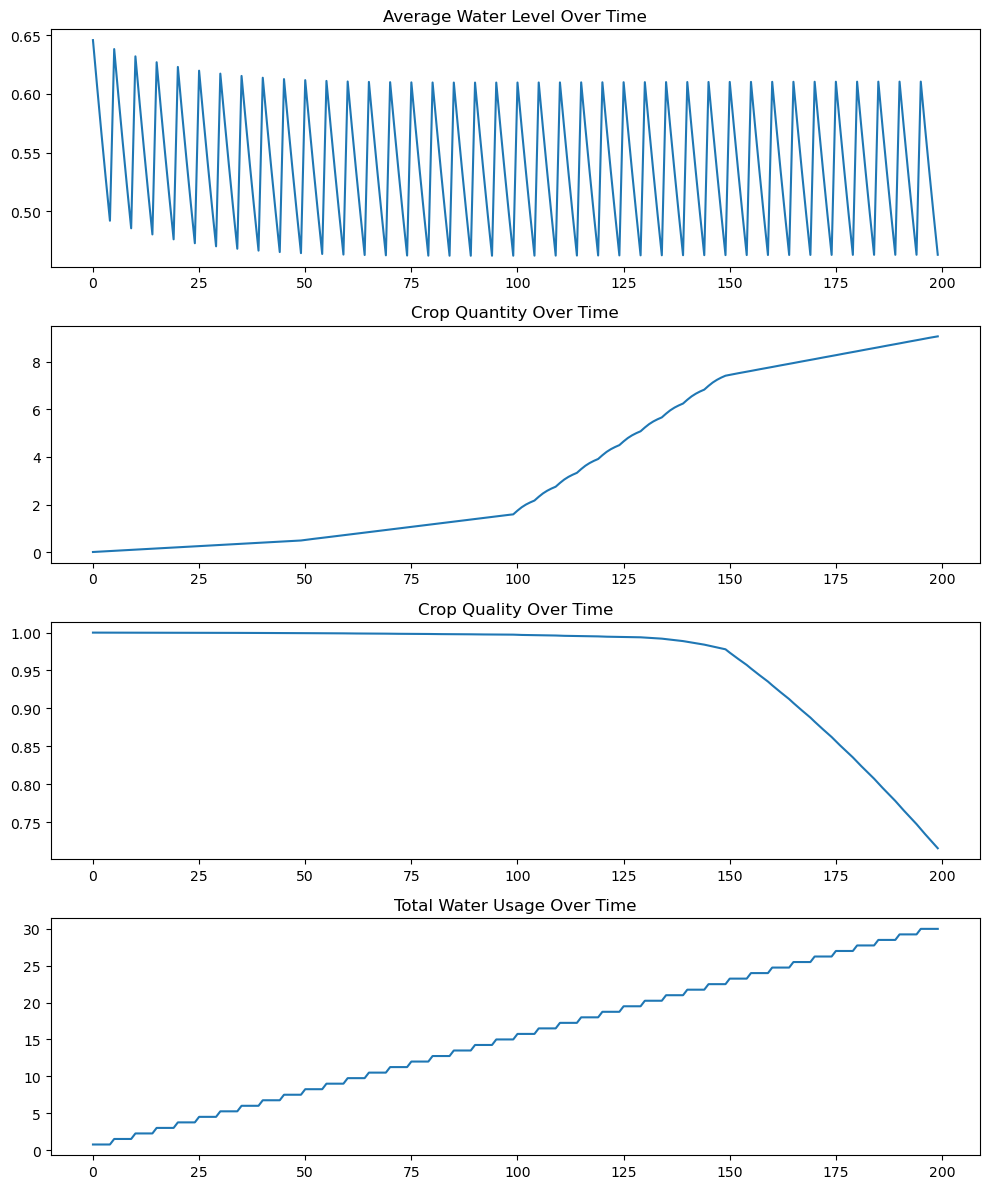

In [113]:
#Example
model = VineyardSurrogate(et_coeff=0.05, rand_et=True)

#Fixed irrigation every 5 days
irrigation_schedule = .75  # inches
done = False
while not done:
    rain = 0.0  # No rain for test
    irr = np.zeros((model.rows, model.cols))
    if model.current_step % 5 == 0:
        irr.fill(irrigation_schedule)
    done, info = model.step(rainfall=rain, irrigation=irr)
    
print("Final Results:")
print(info)
model.plot_histories()  # Would generate plots if run locally

Stage Bud Break completed at step 50
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.497844752617364
Crop State: Quantity=0.49, Quality=1.00


C:\Users\olson\AppData\Local\Temp\ipykernel_50384\3809937657.py:212: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


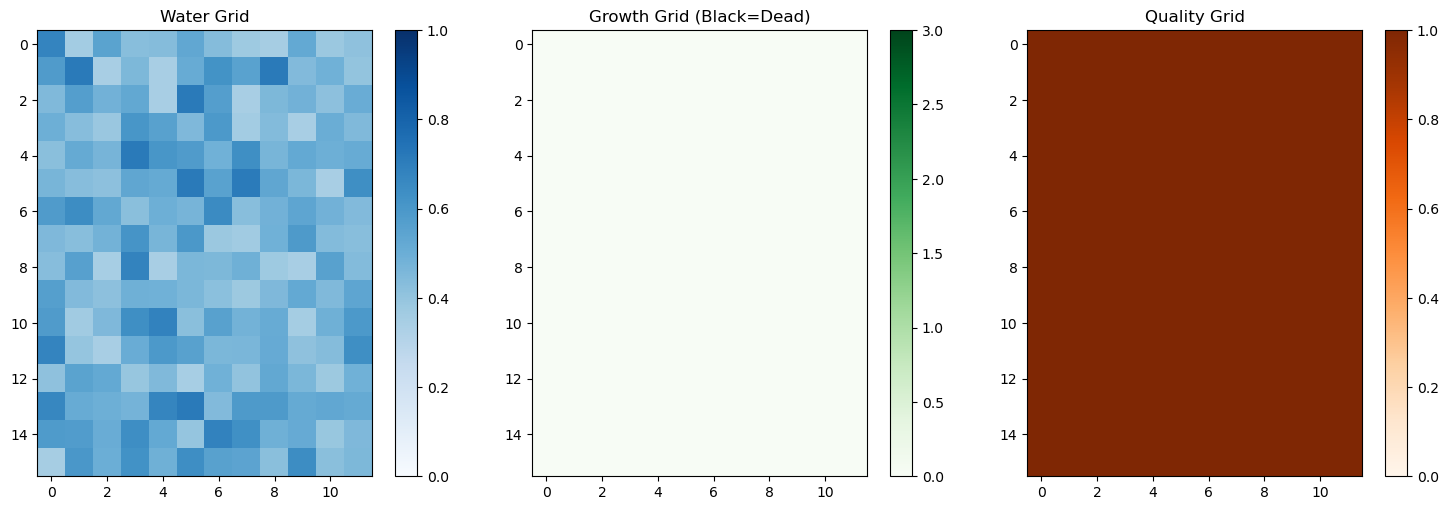

Stage Flowering completed at step 100
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.5072269836264188
Crop State: Quantity=1.57, Quality=1.00


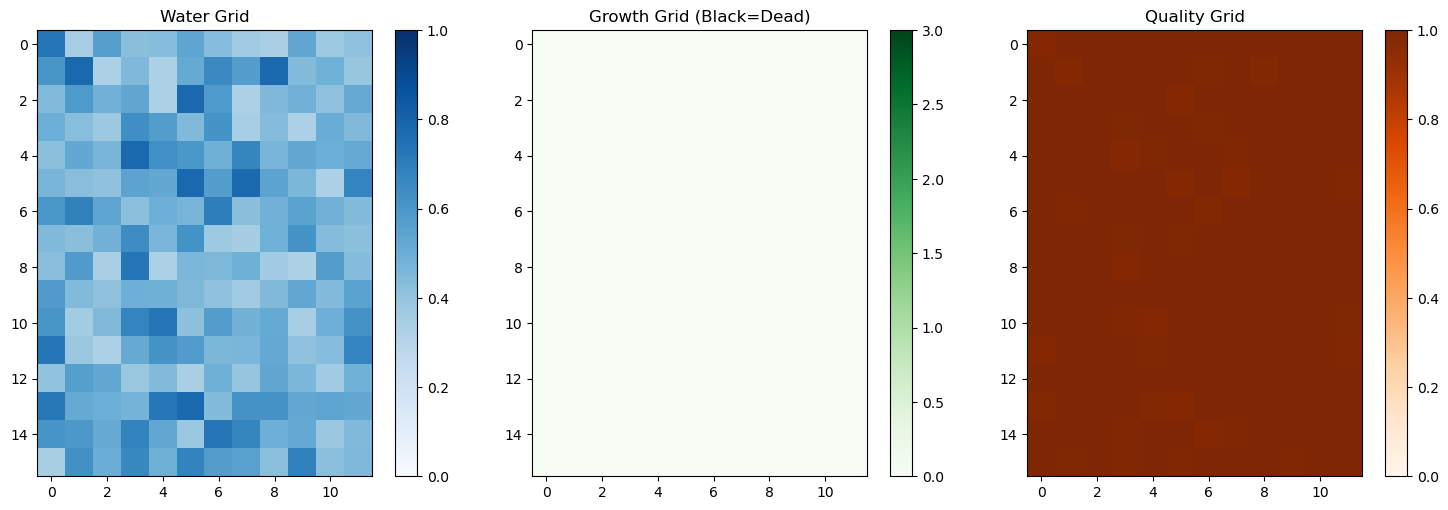

Stage Fruit Set completed at step 150
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.5222731261523545
Crop State: Quantity=6.93, Quality=0.98


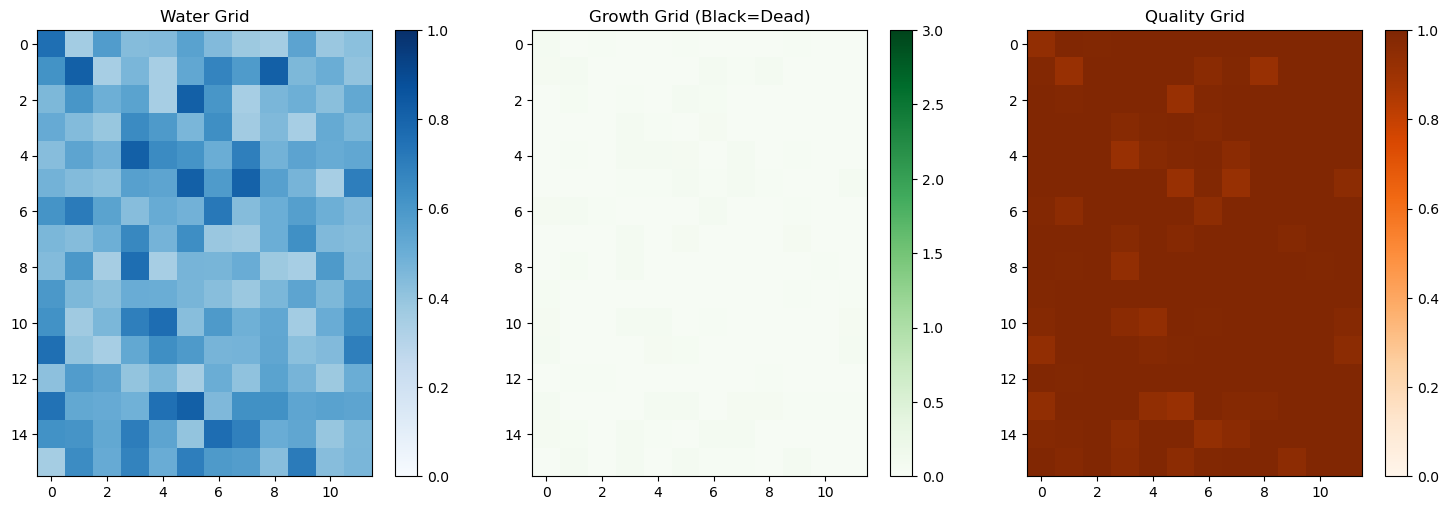

Stage Ripening completed at step 200
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.5367443851623458
Crop State: Quantity=8.55, Quality=0.76


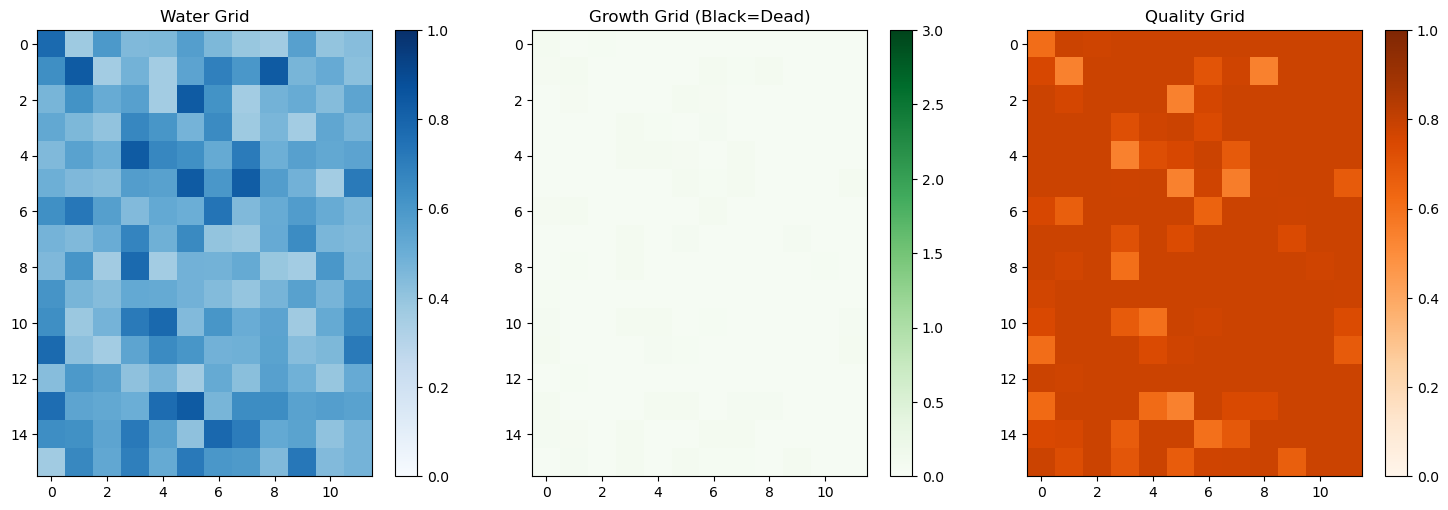

Final Results:
{'quantity': 8.552170000000014, 'quality': 0.7568808913693693, 'water_usage': 30.0, 'stage': 'Harvest', 'step': 200, 'any_dead': False}


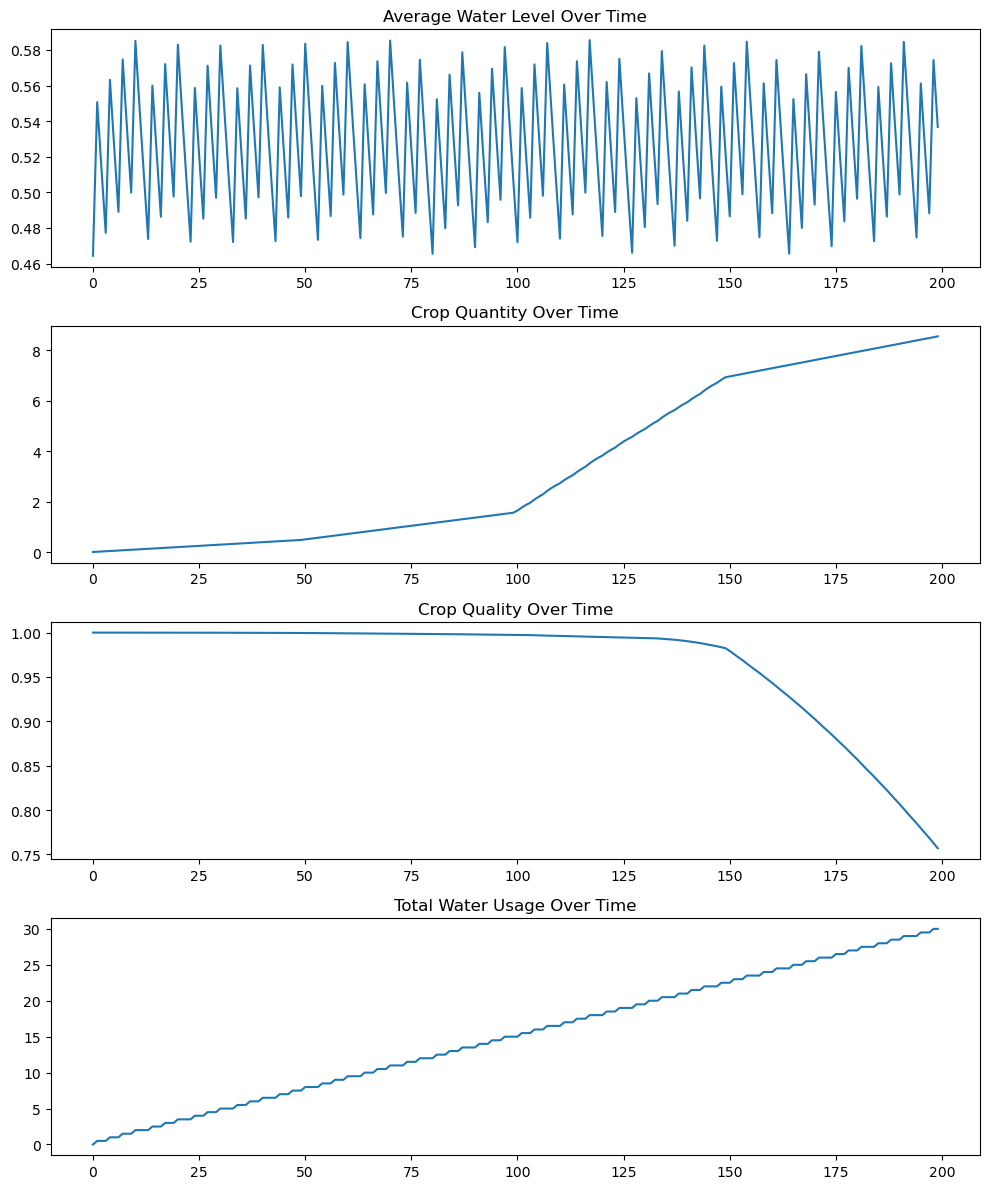

In [114]:
#Example
model = VineyardSurrogate(et_coeff=0.05, rand_et=True)

#Fixed irrigation every 5 days
irrigation_schedule = .5  # inches
done = False
while not done:
    rain = 0.0  # No rain for test
    irr = np.zeros((model.rows, model.cols))
    if np.average(model.water) < 0.5:
        irr.fill(irrigation_schedule)
    done, info = model.step(rainfall=rain, irrigation=irr)
    
print("Final Results:")
print(info)
model.plot_histories()  # Would generate plots if run locally

Stage Bud Break completed at step 50
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.600771137206782
Crop State: Quantity=0.50, Quality=1.00


C:\Users\olson\AppData\Local\Temp\ipykernel_50384\3809937657.py:212: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


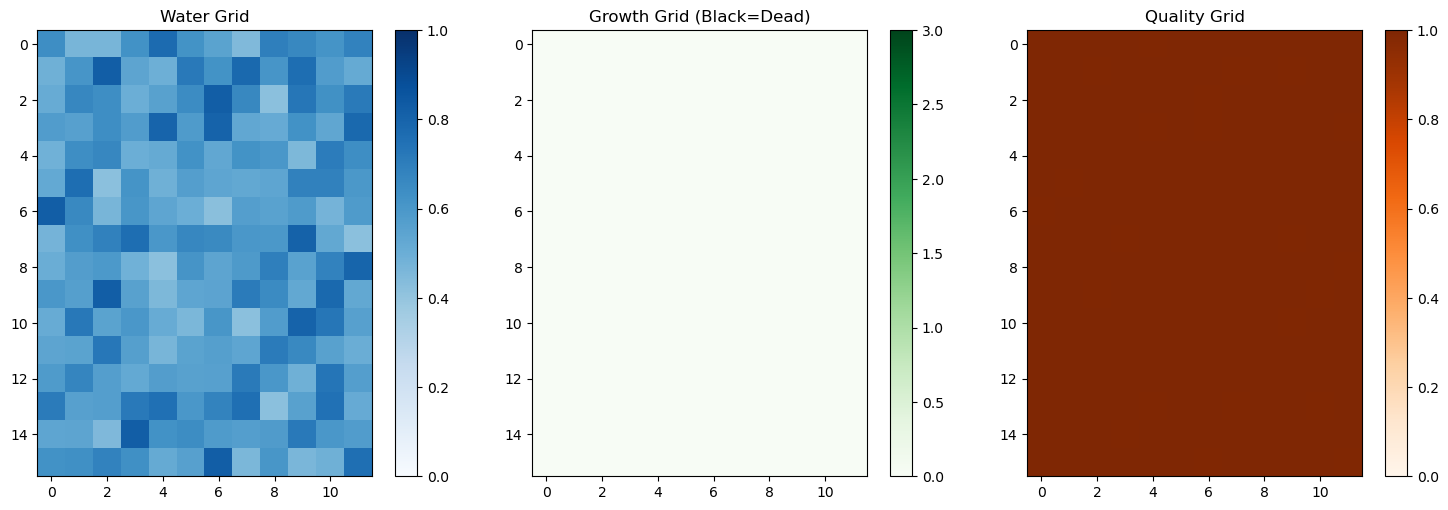

Stage Flowering completed at step 100
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.588560507882105
Crop State: Quantity=1.65, Quality=0.99


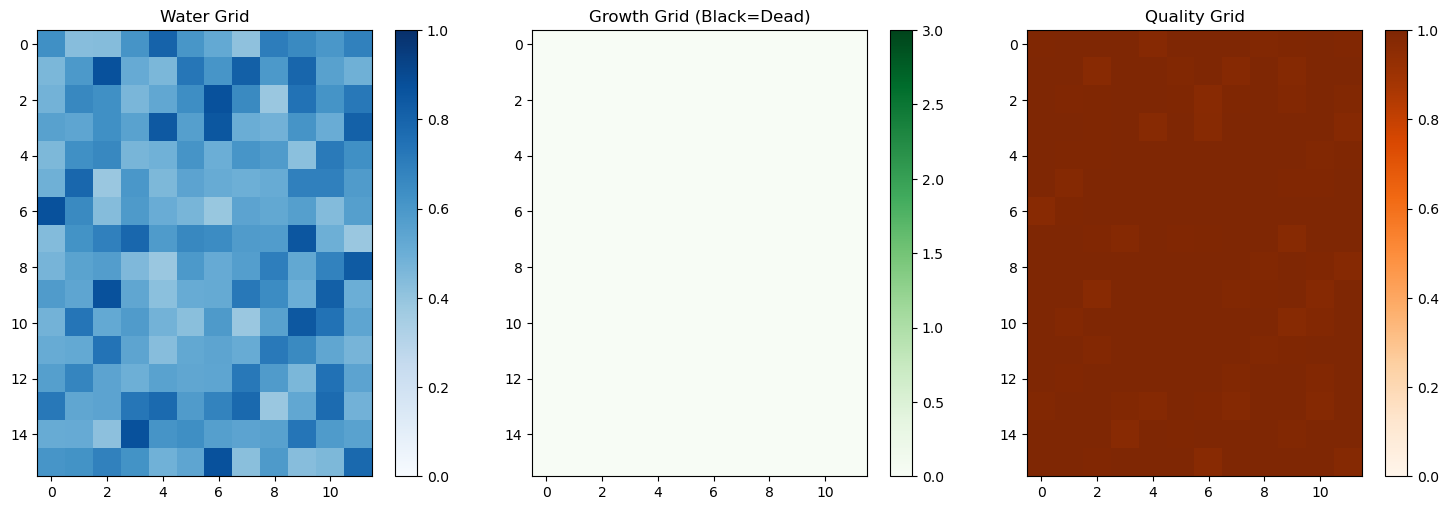

Stage Fruit Set completed at step 150
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.5748300937463285
Crop State: Quantity=8.59, Quality=0.96


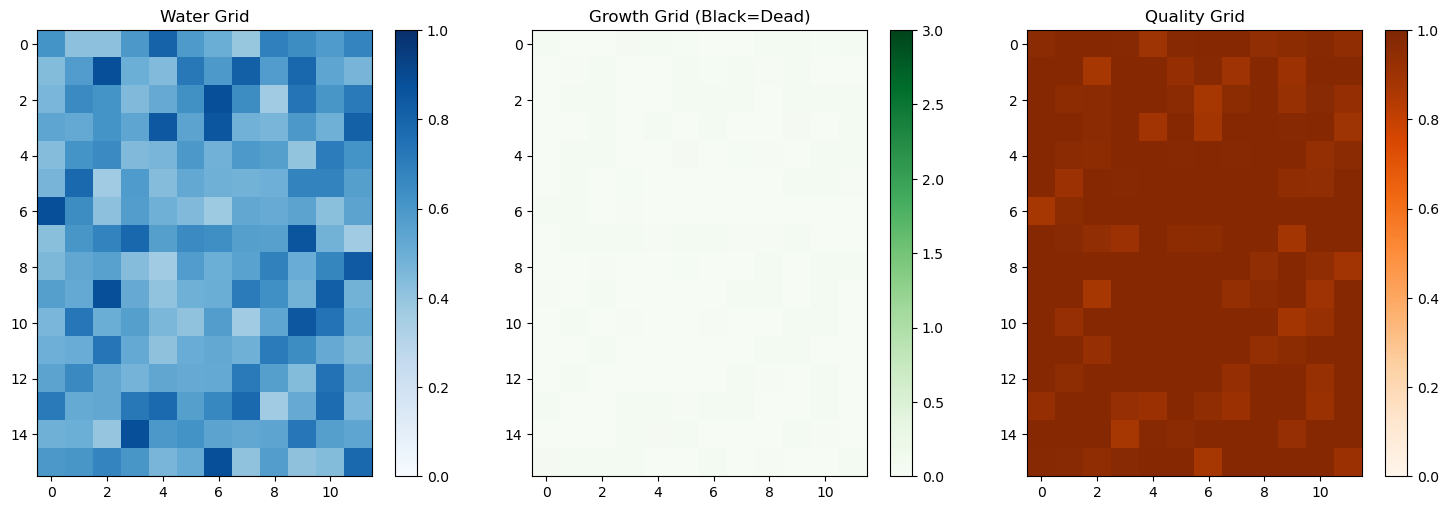

Stage Ripening completed at step 200
Average ET Coefficient: 0.049999999999999996
Average Water Level: 0.6214520665551612
Crop State: Quantity=10.32, Quality=0.59


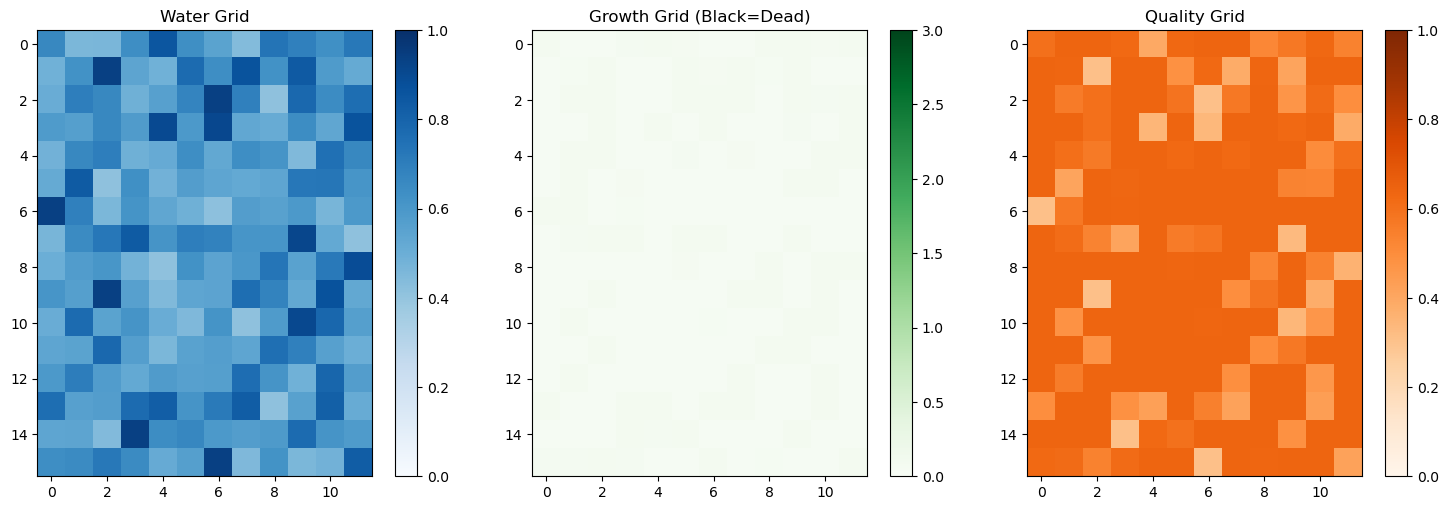

Final Results:
{'quantity': 10.321380000000017, 'quality': 0.5852404824545322, 'water_usage': 31.75, 'stage': 'Harvest', 'step': 200, 'any_dead': False}


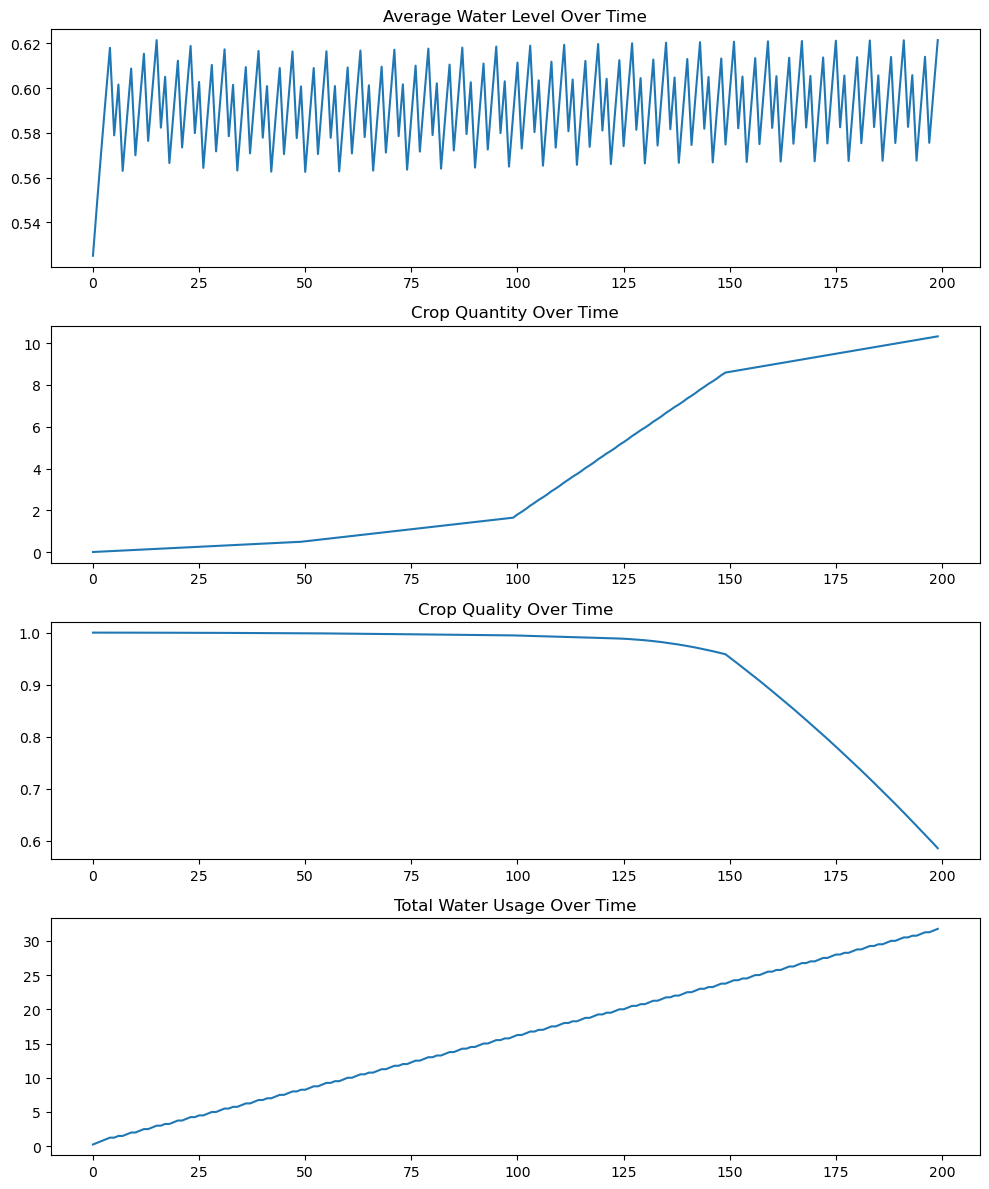

In [121]:
#Example
model = VineyardSurrogate(et_coeff=0.05, rand_et=True)

#Fixed irrigation every 5 days
irrigation_schedule = .25  # inches
done = False
while not done:
    rain = 0.0  # No rain for test
    irr = np.zeros((model.rows, model.cols))
    if np.average(model.water) < 0.6:
        irr.fill(irrigation_schedule)
    done, info = model.step(rainfall=rain, irrigation=irr)
    
print("Final Results:")
print(info)
model.plot_histories()  # Would generate plots if run locally